In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/realwaste-main/RealWaste"

# Define image size and batch size
img_size = (128, 128)
batch_size = 32

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

# Create datasets for training and validation
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(train_dataset.classes)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define a simple CNN model
class WasteClassifier(nn.Module):
    def __init__(self):
        super(WasteClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (img_size[0] // 4) * (img_size[1] // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * (img_size[0] // 4) * (img_size[1] // 4))
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = WasteClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


WasteClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [2]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_train_loss = running_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation loop
    model.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val.item()

    average_val_loss = running_loss_val / len(val_loader)
    val_losses.append(average_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')


Epoch [1/10], Train Loss: 1.8109, Validation Loss: 1.4408
Epoch [2/10], Train Loss: 1.3298, Validation Loss: 1.2993
Epoch [3/10], Train Loss: 1.0798, Validation Loss: 1.0729
Epoch [4/10], Train Loss: 0.8730, Validation Loss: 0.9721
Epoch [5/10], Train Loss: 0.7614, Validation Loss: 1.0320
Epoch [6/10], Train Loss: 0.6059, Validation Loss: 1.0046
Epoch [7/10], Train Loss: 0.4677, Validation Loss: 1.2022
Epoch [8/10], Train Loss: 0.3608, Validation Loss: 1.0744
Epoch [9/10], Train Loss: 0.2883, Validation Loss: 1.1062
Epoch [10/10], Train Loss: 0.1943, Validation Loss: 1.3026


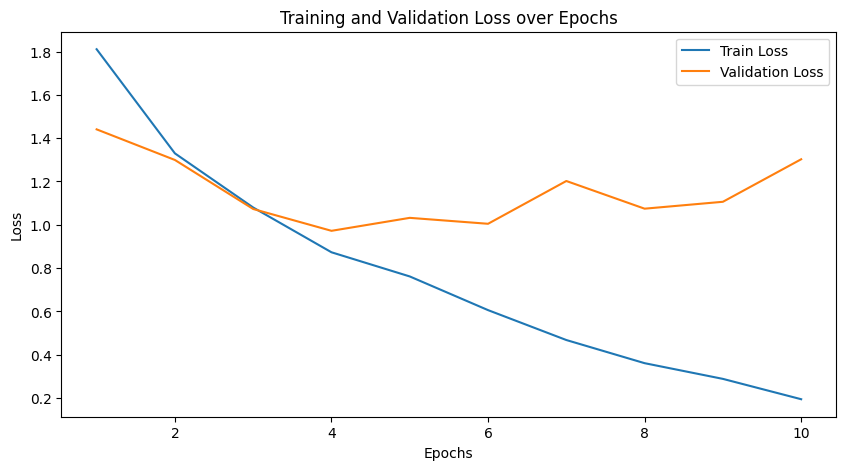

In [3]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), "waste_classifier_model.pth")